<a href="https://colab.research.google.com/github/paddydoc/paddy-doctor-dataset/blob/main/notebooks/resnet34_diseases_small_400_split.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Resnet34 with Fastai Paddy Doctor Dataset

Acknowledgements: https://www.kaggle.com/code/fmussari/fast-resnet34-with-fastai

In [ ]:
import glob

try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

from fastkaggle import *
from fastai.vision.all import *
set_seed(42)

#/kaggle/input/paddy-doctor-diseases-small-400-split

competition = 'paddy-doctor-diseases-small-400-split'
path = setup_comp(competition, install='fastai "timm>=0.6.2.dev0"')
print(path)

# train images
train_path = path / 'train'
train_files = get_image_files(train_path)

# test images
test_path = path/'test'
test_files = get_image_files(test_path).sorted()

# train labels
train_df = pd.read_csv(path / 'metadata-train.csv')
print(train_df.shape)
train_df.label.value_counts()

../input/paddy-doctor-diseases-small-400-split
(4160, 4)


bacterial_leaf_blight       320
bacterial_leaf_streak       320
bacterial_panicle_blight    320
black_stem_borer            320
blast                       320
brown_spot                  320
downy_mildew                320
hispa                       320
leaf_roller                 320
normal                      320
tungro                      320
white_stem_borer            320
yellow_stem_borer           320
Name: label, dtype: int64

#### Dataloaders for fastai training

In [ ]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=RandomSplitter(0.2, seed=42),
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

dls = dblock.dataloaders(train_path)

In [ ]:
dls = ImageDataLoaders.from_folder(
    train_path, 
    valid_pct=0.2,
    seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

### Setlup a learner based on resnet34


In [ ]:
learn = vision_learner(dls, resnet34, metrics=error_rate).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

### Fine-tune the resnet34 model



In [ ]:
%%timeit
learn.fine_tune(10, 0.005)

epoch,train_loss,valid_loss,error_rate,time
0,2.685138,1.609765,0.478365,00:42


epoch,train_loss,valid_loss,error_rate,time
0,1.481797,0.985706,0.293269,00:31
1,1.041613,0.800470,0.241587,00:32
2,0.830209,0.685676,0.206731,00:32
3,0.611233,0.603976,0.168269,00:32
4,0.466132,0.603266,0.167067,00:32
5,0.336607,0.512162,0.140625,00:31
6,0.228107,0.455862,0.109375,00:32
7,0.146138,0.415022,0.104567,00:32
8,0.091947,0.382457,0.090144,00:31
9,0.069495,0.383046,0.093750,00:32


epoch,train_loss,valid_loss,error_rate,time
0,0.079502,0.519643,0.108173,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.127686,0.519507,0.110577,00:32
1,0.162183,0.637025,0.144231,00:31
2,0.352799,1.043971,0.230769,00:31
3,0.359777,0.539406,0.153846,00:32
4,0.304639,0.784951,0.173077,00:32
5,0.230729,0.517380,0.123798,00:32
6,0.148267,0.425867,0.096154,00:32
7,0.096157,0.405006,0.081731,00:32
8,0.059348,0.394569,0.080529,00:31
9,0.044609,0.393243,0.082933,00:31


epoch,train_loss,valid_loss,error_rate,time
0,0.050728,0.474133,0.088942,00:31


epoch,train_loss,valid_loss,error_rate,time
0,0.074610,0.531415,0.103365,00:31
1,0.112039,0.651880,0.128606,00:31
2,0.269197,0.974857,0.186298,00:31
3,0.252217,0.557563,0.131010,00:31
4,0.189490,0.544833,0.110577,00:32
5,0.145393,0.456688,0.108173,00:31
6,0.103357,0.443769,0.088942,00:31
7,0.065258,0.417442,0.081731,00:31
8,0.042374,0.382771,0.076923,00:31
9,0.030760,0.386735,0.076923,00:31


epoch,train_loss,valid_loss,error_rate,time
0,0.030354,0.440168,0.081731,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.038580,0.485077,0.097356,00:31
1,0.106714,0.809986,0.144231,00:31
2,0.165766,0.721741,0.158654,00:31
3,0.176224,0.804414,0.138221,00:31
4,0.162878,0.581125,0.131010,00:31
5,0.114861,0.554797,0.104567,00:31
6,0.089393,0.452594,0.081731,00:31
7,0.055968,0.426757,0.087740,00:31
8,0.036621,0.419077,0.085337,00:31
9,0.030368,0.414403,0.080529,00:31


epoch,train_loss,valid_loss,error_rate,time
0,0.029637,0.450125,0.079327,00:29


epoch,train_loss,valid_loss,error_rate,time
0,0.037197,0.557039,0.087740,00:31
1,0.062891,0.614685,0.104567,00:33
2,0.157832,0.772532,0.147837,00:33
3,0.174732,0.644166,0.122596,00:31
4,0.138204,0.476754,0.104567,00:31
5,0.090523,0.510718,0.100962,00:31
6,0.060011,0.448467,0.085337,00:31
7,0.039874,0.444031,0.082933,00:37
8,0.030889,0.442318,0.084135,00:31
9,0.025354,0.438998,0.080529,00:31


epoch,train_loss,valid_loss,error_rate,time
0,0.017425,0.505596,0.086538,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.028836,0.527213,0.082933,00:31
1,0.060124,0.758973,0.121394,00:31
2,0.122681,0.856843,0.139423,00:31
3,0.163730,0.687561,0.122596,00:31
4,0.124776,0.417906,0.088942,00:31
5,0.078025,0.414046,0.088942,00:31
6,0.056118,0.444958,0.085337,00:31
7,0.034674,0.382846,0.073317,00:31
8,0.024714,0.370913,0.070913,00:31
9,0.020360,0.370193,0.068510,00:31


epoch,train_loss,valid_loss,error_rate,time
0,0.014320,0.440506,0.079327,00:31


epoch,train_loss,valid_loss,error_rate,time
0,0.022235,0.426536,0.079327,00:31
1,0.049135,0.551821,0.092548,00:31
2,0.121601,1.062763,0.177885,00:31
3,0.154135,0.735736,0.125000,00:31
4,0.108706,0.648858,0.109375,00:31
5,0.080207,0.506678,0.093750,00:31
6,0.049098,0.494330,0.086538,00:31
7,0.036124,0.417853,0.074519,00:31
8,0.025514,0.444466,0.079327,00:31
9,0.018760,0.432962,0.078125,00:31


epoch,train_loss,valid_loss,error_rate,time
0,0.017196,0.491807,0.085337,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.018183,0.479059,0.074519,00:31
1,0.038448,0.560046,0.082933,00:31
2,0.102390,0.782122,0.139423,00:31
3,0.140191,0.571300,0.106971,00:31
4,0.101346,0.550634,0.100962,00:31
5,0.072197,0.533455,0.084135,00:31
6,0.042208,0.488353,0.090144,00:31
7,0.029197,0.494310,0.081731,00:31
8,0.018756,0.494030,0.082933,00:31
9,0.014891,0.489686,0.086538,00:31


5min 48s ± 3.39 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Model predictions

In [ ]:
# Get predictions on validation set
probs, target = learn.get_preds(dl=dls.valid)
error_rate(probs, target)

TensorBase(0.0865)

In [ ]:
# Get TTA predictions on validation set
probs, target = learn.tta(dl=dls.valid)
error_rate(probs, target)

TensorBase(0.0757)

In [ ]:
# test images
test_path = path/'test'
test_files = get_image_files(test_path).sorted()
test_classes = [f.parent.name for f in test_files]

probs, _ = learn.tta(dl=dls.test_dl(test_files))
preds = probs.argmax(dim=1)
pred_classes = dls.vocab[preds]

### Results

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

cls_report = classification_report(test_classes, pred_classes, 
                                   digits=5)
print(cls_report)
acc = accuracy_score(test_classes, pred_classes)

                          precision    recall  f1-score   support

   bacterial_leaf_blight    0.92857   0.97500   0.95122        80
   bacterial_leaf_streak    0.98750   0.98750   0.98750        80
bacterial_panicle_blight    0.98765   1.00000   0.99379        80
        black_stem_borer    0.98734   0.97500   0.98113        80
                   blast    0.85897   0.83750   0.84810        80
              brown_spot    0.96000   0.90000   0.92903        80
            downy_mildew    0.89412   0.95000   0.92121        80
                   hispa    0.91250   0.91250   0.91250        80
             leaf_roller    0.98734   0.97500   0.98113        80
                  normal    0.95122   0.97500   0.96296        80
                  tungro    0.94737   0.90000   0.92308        80
        white_stem_borer    0.92683   0.95000   0.93827        80
       yellow_stem_borer    0.97468   0.96250   0.96855        80

                accuracy                        0.94615      1040
        

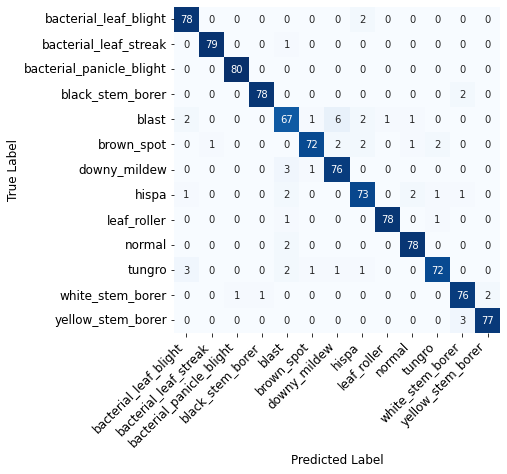

[[78  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0 79  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0 80  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 78  0  0  0  0  0  0  0  2  0]
 [ 2  0  0  0 67  1  6  2  1  1  0  0  0]
 [ 0  1  0  0  0 72  2  2  0  1  2  0  0]
 [ 0  0  0  0  3  1 76  0  0  0  0  0  0]
 [ 1  0  0  0  2  0  0 73  0  2  1  1  0]
 [ 0  0  0  0  1  0  0  0 78  0  1  0  0]
 [ 0  0  0  0  2  0  0  0  0 78  0  0  0]
 [ 3  0  0  0  2  1  1  1  0  0 72  0  0]
 [ 0  0  1  1  0  0  0  0  0  0  0 76  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  3 77]]


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    #ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

class_names = dls.vocab
plot_heatmap(test_classes, pred_classes, class_names, ax, title="Resnet34")   


#fig.suptitle("Confusion Matrix Model Comparison", fontsize=12)
#fig.tight_layout()
#fig.subplots_adjust(top=1.25)
plt.show()
cm = confusion_matrix(test_classes, pred_classes)
print(cm)

In [ ]:
res = pd.DataFrame({"y_true":test_classes,
                      "y_pred":pred_classes})
res.to_csv('result.csv', index=False)
res

,y_true,y_pred
0,bacterial_leaf_blight,bacterial_leaf_blight
1,bacterial_leaf_blight,bacterial_leaf_blight
2,bacterial_leaf_blight,bacterial_leaf_blight
3,bacterial_leaf_blight,bacterial_leaf_blight
4,bacterial_leaf_blight,bacterial_leaf_blight
...,...,...
1035,yellow_stem_borer,yellow_stem_borer
1036,yellow_stem_borer,yellow_stem_borer
1037,yellow_stem_borer,yellow_stem_borer
1038,yellow_stem_borer,yellow_stem_borer
